In [1]:
import os

In [2]:
os.chdir(os.path.expanduser(os.path.split(os.path.abspath(''))[0]))

In [3]:
import datasets
import nltk
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

/home/vlad/miniconda3/envs/py10yolo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Подготовка датасета

In [5]:
import pandas as pd

In [6]:
from src.data.dataset import WordDataset, get_word2ind, collate_fn_with_padding

In [7]:
dataset = datasets.load_dataset(path='ag_news')

Using the latest cached version of the dataset since ag_news couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /home/vlad/.cache/huggingface/datasets/ag_news/default/0.0.0/eb185aade064a813bc0b7f42de02595523103ca4 (last modified on Sun Mar 24 16:54:05 2024).


Составляем словарь, а также соотвествие между словами и индексами и наоборот

In [8]:
word2ind, ind2word, vocab = get_word2ind(dataset, counter_thresh=25)

100%|██████████| 120000/120000 [00:09<00:00, 12794.34it/s]

Размер словаря: 11842


Создание датасета

In [9]:
np.random.seed(42)

train_dataset = WordDataset(dataset['train'], word2ind)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx), word2ind)

In [10]:
pd.Series(train_dataset.data['label']).value_counts()

2    30000
3    30000
1    30000
0    30000
Name: count, dtype: int64

In [11]:
train_dataset.data.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['World', 'Sports', 'Business', 'Sci/Tech'], id=None)}

# Обучение моделей

In [12]:
from src.models.train_model import train

In [13]:
from src.visualization.visualize import show_loss

## Simple RNN

In [16]:
from src.models.architectures import SimpleRNN

### Без подбора параметров

In [12]:
exp_name = f"SimpleRNN_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

model = SimpleRNN(hidden_dim=256,
                  vocab_size=len(vocab),
                  num_classes=4)
model.device = torch.device(device)
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
num_epochs = 30


tb_writer = SummaryWriter(f'models/runs/{exp_name}/board')

first_hist = train(train_dataset=train_dataset, 
                   val_dataset=eval_dataset, 
                   model=model, 
                   epochs=num_epochs, 
                   optimizer=optimizer, 
                   criterion=criterion,
                   batch_size=256, 
                   tb_writer=tb_writer,
                   collate_fn=lambda x: collate_fn_with_padding(x, pad_id=word2ind['<pad>'], device=device),
                   model_dir=f'models/runs/{exp_name}')

train:   3%|▎         | 1/30 [00:17<08:40, 17.94s/it]

Epoch 001 train_loss: 0.7426 val_loss 0.4701 train_acc 0.6874 val_acc 0.8336



train:   7%|▋         | 2/30 [00:35<08:22, 17.94s/it]

Epoch 002 train_loss: 0.3701 val_loss 0.3856 train_acc 0.8751 val_acc 0.8746



train:  10%|█         | 3/30 [00:53<07:58, 17.74s/it]

Epoch 003 train_loss: 0.3104 val_loss 0.3628 train_acc 0.8969 val_acc 0.8780



train:  13%|█▎        | 4/30 [01:10<07:34, 17.48s/it]

Epoch 004 train_loss: 0.3231 val_loss 0.3396 train_acc 0.8909 val_acc 0.8866



train:  17%|█▋        | 5/30 [01:27<07:12, 17.29s/it]

Epoch 005 train_loss: 0.2505 val_loss 0.3460 train_acc 0.9156 val_acc 0.8860



train:  20%|██        | 6/30 [01:44<06:52, 17.17s/it]

Epoch 006 train_loss: 0.2328 val_loss 0.3573 train_acc 0.9206 val_acc 0.8868



train:  23%|██▎       | 7/30 [02:01<06:33, 17.11s/it]

Epoch 007 train_loss: 0.2235 val_loss 0.3403 train_acc 0.9224 val_acc 0.8900



train:  27%|██▋       | 8/30 [02:18<06:15, 17.09s/it]

Epoch 008 train_loss: 0.2151 val_loss 0.3505 train_acc 0.9247 val_acc 0.8916



train:  30%|███       | 9/30 [02:35<05:58, 17.08s/it]

Epoch 009 train_loss: 0.2667 val_loss 0.3042 train_acc 0.9063 val_acc 0.9010



train:  33%|███▎      | 10/30 [02:52<05:40, 17.05s/it]

Epoch 010 train_loss: 0.2038 val_loss 0.3154 train_acc 0.9297 val_acc 0.9014



train:  37%|███▋      | 11/30 [03:09<05:23, 17.02s/it]

Epoch 011 train_loss: 0.1898 val_loss 0.3202 train_acc 0.9333 val_acc 0.9014



train:  40%|████      | 12/30 [03:26<05:06, 17.00s/it]

Epoch 012 train_loss: 0.1822 val_loss 0.3182 train_acc 0.9365 val_acc 0.9022



train:  43%|████▎     | 13/30 [03:43<04:48, 17.00s/it]

Epoch 013 train_loss: 0.1832 val_loss 0.3221 train_acc 0.9355 val_acc 0.8970



train:  47%|████▋     | 14/30 [04:00<04:31, 16.98s/it]

Epoch 014 train_loss: 0.1837 val_loss 0.3310 train_acc 0.9346 val_acc 0.8998



train:  50%|█████     | 15/30 [04:17<04:14, 16.99s/it]

Epoch 015 train_loss: 0.1740 val_loss 0.3286 train_acc 0.9374 val_acc 0.9002



train:  53%|█████▎    | 16/30 [04:34<03:57, 16.99s/it]

Epoch 016 train_loss: 0.1654 val_loss 0.3340 train_acc 0.9407 val_acc 0.9012



train:  57%|█████▋    | 17/30 [04:51<03:40, 16.98s/it]

Epoch 017 train_loss: 0.1620 val_loss 0.3364 train_acc 0.9423 val_acc 0.9022



train:  60%|██████    | 18/30 [05:08<03:23, 16.97s/it]

Epoch 018 train_loss: 0.1573 val_loss 0.3621 train_acc 0.9440 val_acc 0.8960



train:  63%|██████▎   | 19/30 [05:25<03:06, 16.99s/it]

Epoch 019 train_loss: 0.1619 val_loss 0.3844 train_acc 0.9414 val_acc 0.8866



train:  67%|██████▋   | 20/30 [05:42<02:49, 16.99s/it]

Epoch 020 train_loss: 0.1512 val_loss 0.3631 train_acc 0.9448 val_acc 0.8970



train:  70%|███████   | 21/30 [05:59<02:33, 17.01s/it]

Epoch 021 train_loss: 0.1522 val_loss 0.3661 train_acc 0.9440 val_acc 0.8958



train:  73%|███████▎  | 22/30 [06:16<02:15, 16.99s/it]

Epoch 022 train_loss: 0.1472 val_loss 0.3835 train_acc 0.9458 val_acc 0.8978



train:  77%|███████▋  | 23/30 [06:33<01:58, 16.98s/it]

Epoch 023 train_loss: 0.1416 val_loss 0.3621 train_acc 0.9489 val_acc 0.9000



train:  80%|████████  | 24/30 [06:50<01:41, 16.96s/it]

Epoch 024 train_loss: 0.1516 val_loss 0.3766 train_acc 0.9451 val_acc 0.8954



train:  83%|████████▎ | 25/30 [07:06<01:24, 16.93s/it]

Epoch 025 train_loss: 0.1386 val_loss 0.3824 train_acc 0.9502 val_acc 0.9008



train:  87%|████████▋ | 26/30 [07:23<01:07, 16.90s/it]

Epoch 026 train_loss: 0.1361 val_loss 0.3913 train_acc 0.9507 val_acc 0.8978



train:  90%|█████████ | 27/30 [07:40<00:50, 16.89s/it]

Epoch 027 train_loss: 0.1358 val_loss 0.3778 train_acc 0.9502 val_acc 0.9002



train:  93%|█████████▎| 28/30 [07:57<00:33, 16.88s/it]

Epoch 028 train_loss: 0.1327 val_loss 0.4057 train_acc 0.9508 val_acc 0.8972



train:  97%|█████████▋| 29/30 [08:14<00:16, 16.88s/it]

Epoch 029 train_loss: 0.1284 val_loss 0.3904 train_acc 0.9530 val_acc 0.9012



train: 100%|██████████| 30/30 [08:31<00:00, 17.04s/it]

Epoch 030 train_loss: 0.1243 val_loss 0.4184 train_acc 0.9537 val_acc 0.8974



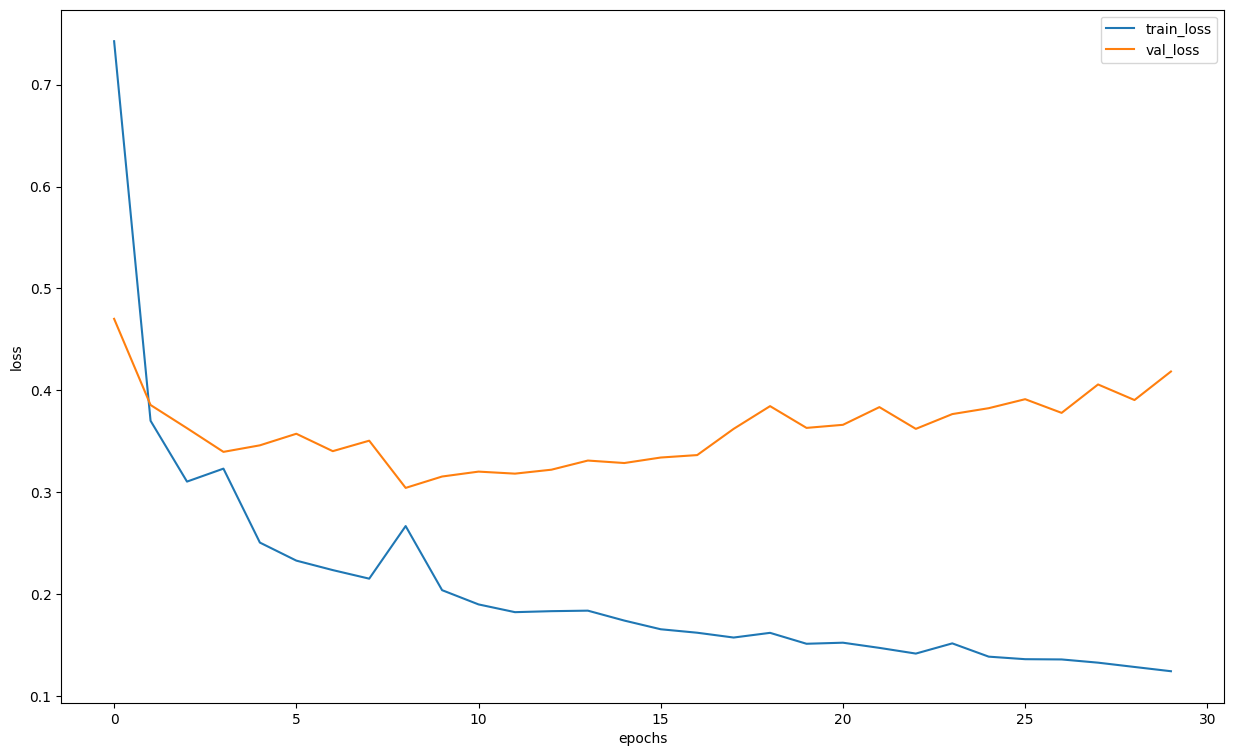

In [13]:
show_loss(first_hist)

### Подбор планировщика для шага обучения

In [17]:
exp_name = f"SimpleRNN_shelduler_StepLR{datetime.now().strftime('%Y%m%d_%H%M%S')}"

model = SimpleRNN(hidden_dim=256,
                  vocab_size=len(vocab),
                  num_classes=4)
model.device = torch.device(device)
model = model.to(device)


criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters())
stepLR = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
num_epochs = 30


tb_writer = SummaryWriter(f'models/runs/{exp_name}/board')

shelduler_hist = train(train_dataset=train_dataset, 
                   val_dataset=eval_dataset, 
                   model=model, 
                   epochs=num_epochs, 
                   optimizer=optimizer, 
                   criterion=criterion,
                   batch_size=256, 
                   tb_writer=tb_writer,
                   collate_fn=lambda x: collate_fn_with_padding(x, pad_id=word2ind['<pad>'], device=device),
                   model_dir=f'models/runs/{exp_name}',
                   scheduler=stepLR)



train:   3%|▎         | 1/30 [00:17<08:41, 17.97s/it]

Epoch 001 train_loss: 0.7385 val_loss 0.4196 train_acc 0.7010 val_acc 0.8594



train:   7%|▋         | 2/30 [00:35<08:22, 17.95s/it]

Epoch 002 train_loss: 0.3736 val_loss 0.3573 train_acc 0.8748 val_acc 0.8848



train:  10%|█         | 3/30 [00:53<08:02, 17.88s/it]

Epoch 003 train_loss: 0.3018 val_loss 0.3481 train_acc 0.8991 val_acc 0.8892



train:  13%|█▎        | 4/30 [01:11<07:47, 18.00s/it]

Epoch 004 train_loss: 0.2681 val_loss 0.3284 train_acc 0.9100 val_acc 0.8908



train:  17%|█▋        | 5/30 [01:30<07:31, 18.05s/it]

Epoch 005 train_loss: 0.2861 val_loss 0.3317 train_acc 0.9018 val_acc 0.8868



train:  20%|██        | 6/30 [01:48<07:13, 18.05s/it]

Epoch 006 train_loss: 0.2285 val_loss 0.3318 train_acc 0.9219 val_acc 0.8878



train:  23%|██▎       | 7/30 [02:06<06:55, 18.08s/it]

Epoch 007 train_loss: 0.2585 val_loss 0.3287 train_acc 0.9125 val_acc 0.8914



train:  27%|██▋       | 8/30 [02:24<06:37, 18.08s/it]

Epoch 008 train_loss: 0.2286 val_loss 0.3053 train_acc 0.9202 val_acc 0.9028



train:  30%|███       | 9/30 [02:42<06:19, 18.07s/it]

Epoch 009 train_loss: 0.2031 val_loss 0.3076 train_acc 0.9306 val_acc 0.9018



train:  33%|███▎      | 10/30 [03:00<06:01, 18.05s/it]

Epoch 010 train_loss: 0.1900 val_loss 0.3578 train_acc 0.9346 val_acc 0.8890



train:  37%|███▋      | 11/30 [03:18<05:42, 18.01s/it]

Epoch 011 train_loss: 0.1865 val_loss 0.3121 train_acc 0.9353 val_acc 0.8980



train:  40%|████      | 12/30 [03:36<05:25, 18.07s/it]

Epoch 012 train_loss: 0.1786 val_loss 0.3213 train_acc 0.9373 val_acc 0.8994



train:  43%|████▎     | 13/30 [03:54<05:06, 18.04s/it]

Epoch 013 train_loss: 0.1720 val_loss 0.3246 train_acc 0.9387 val_acc 0.8984



train:  47%|████▋     | 14/30 [04:12<04:49, 18.07s/it]

Epoch 014 train_loss: 0.1680 val_loss 0.3563 train_acc 0.9404 val_acc 0.8914



train:  50%|█████     | 15/30 [04:30<04:30, 18.05s/it]

Epoch 015 train_loss: 0.1613 val_loss 0.3735 train_acc 0.9429 val_acc 0.8874



train:  53%|█████▎    | 16/30 [04:48<04:13, 18.09s/it]

Epoch 016 train_loss: 0.1660 val_loss 0.3436 train_acc 0.9401 val_acc 0.8982



train:  57%|█████▋    | 17/30 [05:06<03:54, 18.01s/it]

Epoch 017 train_loss: 0.1612 val_loss 0.3330 train_acc 0.9429 val_acc 0.8994



train:  60%|██████    | 18/30 [05:24<03:36, 18.05s/it]

Epoch 018 train_loss: 0.1557 val_loss 0.3430 train_acc 0.9434 val_acc 0.8996



train:  63%|██████▎   | 19/30 [05:42<03:18, 18.02s/it]

Epoch 019 train_loss: 0.1476 val_loss 0.3465 train_acc 0.9473 val_acc 0.8988



train:  67%|██████▋   | 20/30 [06:00<02:59, 17.98s/it]

Epoch 020 train_loss: 0.1509 val_loss 0.3576 train_acc 0.9446 val_acc 0.8958



train:  70%|███████   | 21/30 [06:18<02:42, 18.02s/it]

Epoch 021 train_loss: 0.1498 val_loss 0.3801 train_acc 0.9460 val_acc 0.8906



train:  70%|███████   | 21/30 [06:27<02:46, 18.46s/it]


KeyboardInterrupt: 

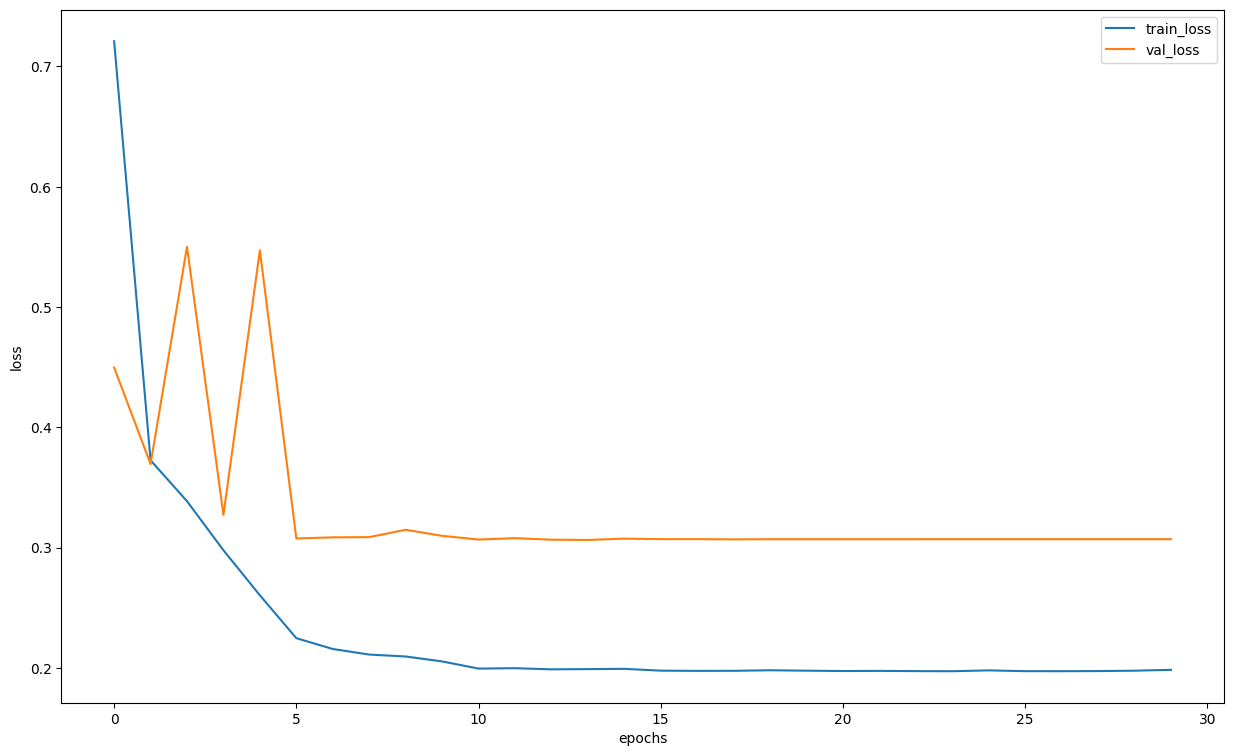

In [15]:
show_loss(shelduler_hist)

### Изменение вероятности dropout

In [14]:
exp_name = f"SimpleRNN_Dropout_04_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

model = SimpleRNN(hidden_dim=256,
                  vocab_size=len(vocab),
                  num_classes=4,
                  dropout_p=0.4)
model.device = torch.device(device)
model = model.to(device)


criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters())
# stepLR = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
num_epochs = 30


tb_writer = SummaryWriter(f'models/runs/{exp_name}/board')

shelduler_hist = train(train_dataset=train_dataset, 
                   val_dataset=eval_dataset, 
                   model=model, 
                   epochs=num_epochs, 
                   optimizer=optimizer, 
                   criterion=criterion,
                   batch_size=256, 
                   tb_writer=tb_writer,
                   collate_fn=lambda x: collate_fn_with_padding(x, pad_id=word2ind['<pad>'], device=device),
                   model_dir=f'models/runs/{exp_name}')

train:   3%|▎         | 1/30 [00:36<17:33, 36.33s/it]

Epoch 001 train_loss: 0.7447 val_loss 0.4332 train_acc 0.6914 val_acc 0.8530



train:   7%|▋         | 2/30 [01:01<13:57, 29.90s/it]

Epoch 002 train_loss: 0.3580 val_loss 0.3763 train_acc 0.8790 val_acc 0.8828



train:  10%|█         | 3/30 [01:26<12:29, 27.76s/it]

Epoch 003 train_loss: 0.3042 val_loss 0.3392 train_acc 0.8973 val_acc 0.8964



train:  13%|█▎        | 4/30 [01:52<11:35, 26.75s/it]

Epoch 004 train_loss: 0.2600 val_loss 0.3393 train_acc 0.9130 val_acc 0.8970



train:  17%|█▋        | 5/30 [02:17<10:55, 26.22s/it]

Epoch 005 train_loss: 0.2389 val_loss 0.3336 train_acc 0.9186 val_acc 0.9024



train:  20%|██        | 6/30 [02:43<10:24, 26.00s/it]

Epoch 006 train_loss: 0.3208 val_loss 0.3366 train_acc 0.8926 val_acc 0.8978



train:  23%|██▎       | 7/30 [03:08<09:54, 25.83s/it]

Epoch 007 train_loss: 0.2248 val_loss 0.3294 train_acc 0.9242 val_acc 0.9056



train:  27%|██▋       | 8/30 [03:34<09:26, 25.75s/it]

Epoch 008 train_loss: 0.2083 val_loss 0.3416 train_acc 0.9290 val_acc 0.8984



train:  30%|███       | 9/30 [03:59<08:59, 25.67s/it]

Epoch 009 train_loss: 0.2001 val_loss 0.3314 train_acc 0.9313 val_acc 0.9038



train:  33%|███▎      | 10/30 [04:25<08:33, 25.68s/it]

Epoch 010 train_loss: 0.1903 val_loss 0.3430 train_acc 0.9349 val_acc 0.9000



train:  37%|███▋      | 11/30 [04:50<08:07, 25.68s/it]

Epoch 011 train_loss: 0.1875 val_loss 0.3471 train_acc 0.9354 val_acc 0.9038



train:  40%|████      | 12/30 [05:16<07:40, 25.58s/it]

Epoch 012 train_loss: 0.1840 val_loss 0.3664 train_acc 0.9360 val_acc 0.8984



train:  43%|████▎     | 13/30 [05:41<07:15, 25.60s/it]

Epoch 013 train_loss: 0.1744 val_loss 0.3533 train_acc 0.9385 val_acc 0.9010



train:  47%|████▋     | 14/30 [06:07<06:48, 25.55s/it]

Epoch 014 train_loss: 0.1733 val_loss 0.3653 train_acc 0.9386 val_acc 0.9008



train:  50%|█████     | 15/30 [06:32<06:22, 25.53s/it]

Epoch 015 train_loss: 0.1740 val_loss 0.3832 train_acc 0.9387 val_acc 0.8974



train:  53%|█████▎    | 16/30 [06:57<05:55, 25.40s/it]

Epoch 016 train_loss: 0.1693 val_loss 0.3772 train_acc 0.9405 val_acc 0.8972



train:  57%|█████▋    | 17/30 [07:23<05:29, 25.37s/it]

Epoch 017 train_loss: 0.1591 val_loss 0.3840 train_acc 0.9439 val_acc 0.8996



train:  60%|██████    | 18/30 [07:48<05:04, 25.37s/it]

Epoch 018 train_loss: 0.1579 val_loss 0.3939 train_acc 0.9436 val_acc 0.9006



train:  63%|██████▎   | 19/30 [08:14<04:39, 25.44s/it]

Epoch 019 train_loss: 0.1579 val_loss 0.3997 train_acc 0.9433 val_acc 0.9018



train:  67%|██████▋   | 20/30 [08:39<04:14, 25.42s/it]

Epoch 020 train_loss: 0.1537 val_loss 0.4132 train_acc 0.9445 val_acc 0.8964



train:  67%|██████▋   | 20/30 [08:59<04:29, 26.96s/it]


KeyboardInterrupt: 

### Изменение вероятности dropout и размера скрытого слоя

In [16]:
exp_name = f"SimpleRNN_Hidden_128_Dropout_04_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

model = SimpleRNN(hidden_dim=128,
                  vocab_size=len(vocab),
                  num_classes=4,
                  dropout_p=0.4)
model.device = torch.device(device)
model = model.to(device)


criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters())
# stepLR = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
num_epochs = 30


tb_writer = SummaryWriter(f'models/runs/{exp_name}/board')

shelduler_hist = train(train_dataset=train_dataset, 
                   val_dataset=eval_dataset, 
                   model=model, 
                   epochs=num_epochs, 
                   optimizer=optimizer, 
                   criterion=criterion,
                   batch_size=256, 
                   tb_writer=tb_writer,
                   collate_fn=lambda x: collate_fn_with_padding(x, pad_id=word2ind['<pad>'], device=device),
                   model_dir=f'models/runs/{exp_name}')

train:   3%|▎         | 1/30 [00:24<11:44, 24.31s/it]

Epoch 001 train_loss: 0.8275 val_loss 0.4709 train_acc 0.6495 val_acc 0.8396



train:   7%|▋         | 2/30 [00:48<11:23, 24.41s/it]

Epoch 002 train_loss: 0.3950 val_loss 0.3925 train_acc 0.8669 val_acc 0.8786



train:  10%|█         | 3/30 [01:13<10:59, 24.44s/it]

Epoch 003 train_loss: 0.3288 val_loss 0.4159 train_acc 0.8914 val_acc 0.8658



train:  13%|█▎        | 4/30 [01:37<10:35, 24.45s/it]

Epoch 004 train_loss: 0.2851 val_loss 0.3473 train_acc 0.9056 val_acc 0.8950



train:  17%|█▋        | 5/30 [02:02<10:14, 24.57s/it]

Epoch 005 train_loss: 0.2564 val_loss 0.3538 train_acc 0.9144 val_acc 0.8946



train:  20%|██        | 6/30 [02:26<09:47, 24.47s/it]

Epoch 006 train_loss: 0.2419 val_loss 0.3341 train_acc 0.9182 val_acc 0.9032



train:  23%|██▎       | 7/30 [02:51<09:21, 24.41s/it]

Epoch 007 train_loss: 0.2285 val_loss 0.3406 train_acc 0.9230 val_acc 0.9038



train:  27%|██▋       | 8/30 [03:15<08:55, 24.36s/it]

Epoch 008 train_loss: 0.2156 val_loss 0.5918 train_acc 0.9267 val_acc 0.8380



train:  30%|███       | 9/30 [03:39<08:30, 24.31s/it]

Epoch 009 train_loss: 0.2125 val_loss 0.3533 train_acc 0.9271 val_acc 0.8980



train:  33%|███▎      | 10/30 [04:03<08:06, 24.32s/it]

Epoch 010 train_loss: 0.1990 val_loss 0.3534 train_acc 0.9321 val_acc 0.8970



train:  37%|███▋      | 11/30 [04:28<07:42, 24.33s/it]

Epoch 011 train_loss: 0.2091 val_loss 0.3494 train_acc 0.9289 val_acc 0.8894



train:  40%|████      | 12/30 [04:52<07:18, 24.38s/it]

Epoch 012 train_loss: 0.2039 val_loss 0.3436 train_acc 0.9296 val_acc 0.9022



train:  43%|████▎     | 13/30 [05:17<06:55, 24.42s/it]

Epoch 013 train_loss: 0.1810 val_loss 0.3814 train_acc 0.9377 val_acc 0.8912



train:  47%|████▋     | 14/30 [05:41<06:31, 24.47s/it]

Epoch 014 train_loss: 0.1757 val_loss 0.3544 train_acc 0.9388 val_acc 0.9010



train:  50%|█████     | 15/30 [06:06<06:07, 24.47s/it]

Epoch 015 train_loss: 0.1812 val_loss 0.4040 train_acc 0.9365 val_acc 0.8804



train:  53%|█████▎    | 16/30 [06:30<05:42, 24.44s/it]

Epoch 016 train_loss: 0.1835 val_loss 0.3678 train_acc 0.9357 val_acc 0.9002



train:  57%|█████▋    | 17/30 [06:55<05:17, 24.42s/it]

Epoch 017 train_loss: 0.1649 val_loss 0.3715 train_acc 0.9425 val_acc 0.9002



train:  60%|██████    | 18/30 [07:19<04:53, 24.44s/it]

Epoch 018 train_loss: 0.1622 val_loss 0.3702 train_acc 0.9433 val_acc 0.8978



train:  63%|██████▎   | 19/30 [07:44<04:29, 24.46s/it]

Epoch 019 train_loss: 0.1659 val_loss 0.3914 train_acc 0.9415 val_acc 0.8932



train:  67%|██████▋   | 20/30 [08:08<04:04, 24.47s/it]

Epoch 020 train_loss: 0.1572 val_loss 0.3862 train_acc 0.9447 val_acc 0.8966



train:  70%|███████   | 21/30 [08:32<03:40, 24.46s/it]

Epoch 021 train_loss: 0.1543 val_loss 0.3885 train_acc 0.9455 val_acc 0.8968



train:  70%|███████   | 21/30 [08:48<03:46, 25.15s/it]


KeyboardInterrupt: 

## LSTM

In [17]:
from src.models.architectures import SimpleLSTM

In [18]:
exp_name = f"SimpleLSTM_128_04_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

model = SimpleLSTM(embedding_dim=100, 
                   hidden_dim=128,
                   vocab_size=len(vocab),
                   num_classes=4)
model.device = torch.device(device)
model = model.to(device)


criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters())
# stepLR = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
num_epochs = 30


tb_writer = SummaryWriter(f'models/runs/{exp_name}/board')

shelduler_hist = train(train_dataset=train_dataset, 
                   val_dataset=eval_dataset, 
                   model=model, 
                   epochs=num_epochs, 
                   optimizer=optimizer, 
                   criterion=criterion,
                   batch_size=256, 
                   tb_writer=tb_writer,
                   collate_fn=lambda x: collate_fn_with_padding(x, pad_id=word2ind['<pad>'], device=device),
                   model_dir=f'models/runs/{exp_name}')

/home/vlad/miniconda3/envs/py10yolo/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
train:   0%|          | 0/30 [00:00<?, ?it/s]

train:   3%|▎         | 1/30 [00:17<08:39, 17.91s/it]

Epoch 001 train_loss: 1.3717 val_loss 1.2677 train_acc 0.2763 val_acc 0.4214



train:   7%|▋         | 2/30 [00:35<08:19, 17.85s/it]

Epoch 002 train_loss: 1.1900 val_loss 1.0985 train_acc 0.4503 val_acc 0.5306



train:  10%|█         | 3/30 [00:53<08:01, 17.84s/it]

Epoch 003 train_loss: 1.0717 val_loss 1.1247 train_acc 0.5612 val_acc 0.4708



train:  13%|█▎        | 4/30 [01:11<07:43, 17.82s/it]

Epoch 004 train_loss: 1.0171 val_loss 0.9868 train_acc 0.5990 val_acc 0.6172



train:  17%|█▋        | 5/30 [01:29<07:27, 17.89s/it]

Epoch 005 train_loss: 0.9649 val_loss 0.9985 train_acc 0.6297 val_acc 0.6058



train:  20%|██        | 6/30 [01:47<07:11, 17.96s/it]

Epoch 006 train_loss: 0.9590 val_loss 0.9692 train_acc 0.6336 val_acc 0.6310



train:  23%|██▎       | 7/30 [02:05<06:51, 17.91s/it]

Epoch 007 train_loss: 0.9350 val_loss 0.9452 train_acc 0.6559 val_acc 0.6428



train:  27%|██▋       | 8/30 [02:23<06:34, 17.94s/it]

Epoch 008 train_loss: 0.9329 val_loss 0.9493 train_acc 0.6557 val_acc 0.6418



train:  30%|███       | 9/30 [02:41<06:15, 17.90s/it]

Epoch 009 train_loss: 0.9205 val_loss 0.9365 train_acc 0.6667 val_acc 0.6530



train:  33%|███▎      | 10/30 [02:58<05:56, 17.84s/it]

Epoch 010 train_loss: 0.9086 val_loss 0.9297 train_acc 0.6786 val_acc 0.6582



train:  37%|███▋      | 11/30 [03:16<05:38, 17.81s/it]

Epoch 011 train_loss: 0.9037 val_loss 0.9215 train_acc 0.7554 val_acc 0.8598



train:  40%|████      | 12/30 [03:34<05:19, 17.78s/it]

Epoch 012 train_loss: 0.8522 val_loss 0.8606 train_acc 0.8957 val_acc 0.8748



train:  43%|████▎     | 13/30 [03:52<05:03, 17.85s/it]

Epoch 013 train_loss: 0.8336 val_loss 0.8537 train_acc 0.9051 val_acc 0.8830



train:  47%|████▋     | 14/30 [04:10<04:46, 17.89s/it]

Epoch 014 train_loss: 0.8264 val_loss 0.8494 train_acc 0.9120 val_acc 0.8862



train:  50%|█████     | 15/30 [04:28<04:27, 17.86s/it]

Epoch 015 train_loss: 0.8240 val_loss 0.8520 train_acc 0.9151 val_acc 0.8850



train:  53%|█████▎    | 16/30 [04:45<04:09, 17.83s/it]

Epoch 016 train_loss: 0.8200 val_loss 0.8495 train_acc 0.9185 val_acc 0.8862



train:  57%|█████▋    | 17/30 [05:03<03:51, 17.79s/it]

Epoch 017 train_loss: 0.8190 val_loss 0.8514 train_acc 0.9195 val_acc 0.8850



train:  60%|██████    | 18/30 [05:21<03:34, 17.87s/it]

Epoch 018 train_loss: 0.8157 val_loss 0.8507 train_acc 0.9231 val_acc 0.8872



train:  63%|██████▎   | 19/30 [05:39<03:16, 17.88s/it]

Epoch 019 train_loss: 0.8157 val_loss 0.8476 train_acc 0.9234 val_acc 0.8902



train:  67%|██████▋   | 20/30 [05:57<02:57, 17.80s/it]

Epoch 020 train_loss: 0.8104 val_loss 0.8419 train_acc 0.9296 val_acc 0.8950



train:  70%|███████   | 21/30 [06:14<02:39, 17.70s/it]

Epoch 021 train_loss: 0.8082 val_loss 0.8446 train_acc 0.9320 val_acc 0.8948



train:  73%|███████▎  | 22/30 [06:32<02:21, 17.69s/it]

Epoch 022 train_loss: 0.8067 val_loss 0.8413 train_acc 0.9337 val_acc 0.8998



train:  77%|███████▋  | 23/30 [06:49<02:03, 17.59s/it]

Epoch 023 train_loss: 0.8046 val_loss 0.8400 train_acc 0.9357 val_acc 0.8972



train:  80%|████████  | 24/30 [07:06<01:45, 17.53s/it]

Epoch 024 train_loss: 0.8030 val_loss 0.8400 train_acc 0.9377 val_acc 0.9016



train:  83%|████████▎ | 25/30 [07:24<01:27, 17.46s/it]

Epoch 025 train_loss: 0.8016 val_loss 0.8394 train_acc 0.9393 val_acc 0.8992



train:  87%|████████▋ | 26/30 [07:41<01:09, 17.40s/it]

Epoch 026 train_loss: 0.8007 val_loss 0.8391 train_acc 0.9402 val_acc 0.8996



train:  90%|█████████ | 27/30 [07:59<00:52, 17.45s/it]

Epoch 027 train_loss: 0.8011 val_loss 0.8417 train_acc 0.9402 val_acc 0.8986



train:  93%|█████████▎| 28/30 [08:16<00:35, 17.55s/it]

Epoch 028 train_loss: 0.7992 val_loss 0.8443 train_acc 0.9425 val_acc 0.8958



train:  97%|█████████▋| 29/30 [08:34<00:17, 17.51s/it]

Epoch 029 train_loss: 0.7988 val_loss 0.8388 train_acc 0.9428 val_acc 0.9000



train: 100%|██████████| 30/30 [08:51<00:00, 17.73s/it]

Epoch 030 train_loss: 0.7955 val_loss 0.8362 train_acc 0.9465 val_acc 0.9048



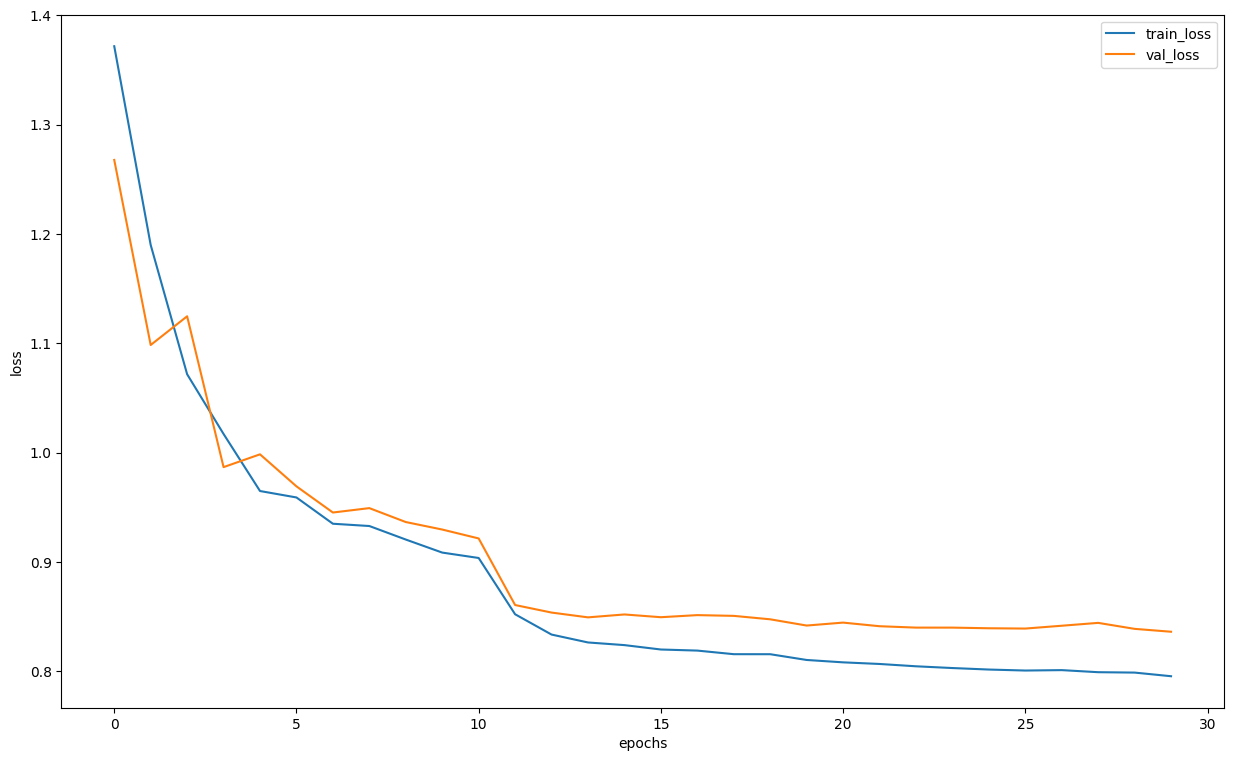

In [22]:
show_loss(shelduler_hist)

Заметим, что модель не доучилась, поставим обучаться дальше

In [20]:
exp_name = f"SimpleLSTM_128_04_continue{datetime.now().strftime('%Y%m%d_%H%M%S')}"

model = SimpleLSTM(embedding_dim=100, 
                   hidden_dim=128,
                   vocab_size=len(vocab),
                   num_classes=4)
model.load_state_dict(torch.load('models/runs/SimpleLSTM_128_04_20240328_122420/last.pt'))
model.device = torch.device(device)
model = model.to(device)


criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters())
# stepLR = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
num_epochs = 30


tb_writer = SummaryWriter(f'models/runs/{exp_name}/board')

shelduler_hist = train(train_dataset=train_dataset, 
                   val_dataset=eval_dataset, 
                   model=model, 
                   epochs=num_epochs, 
                   optimizer=optimizer, 
                   criterion=criterion,
                   batch_size=256, 
                   tb_writer=tb_writer,
                   collate_fn=lambda x: collate_fn_with_padding(x, pad_id=word2ind['<pad>'], device=device),
                   model_dir=f'models/runs/{exp_name}')

/home/vlad/miniconda3/envs/py10yolo/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
train:   0%|          | 0/30 [00:00<?, ?it/s]

train:   3%|▎         | 1/30 [00:18<08:42, 18.01s/it]

Epoch 001 train_loss: 0.7950 val_loss 0.8388 train_acc 0.9472 val_acc 0.9002



train:   7%|▋         | 2/30 [00:35<08:20, 17.86s/it]

Epoch 002 train_loss: 0.7938 val_loss 0.8406 train_acc 0.9486 val_acc 0.9002



train:  10%|█         | 3/30 [00:53<08:03, 17.89s/it]

Epoch 003 train_loss: 0.7920 val_loss 0.8395 train_acc 0.9508 val_acc 0.9006



train:  13%|█▎        | 4/30 [01:11<07:46, 17.93s/it]

Epoch 004 train_loss: 0.7930 val_loss 0.8410 train_acc 0.9497 val_acc 0.8976



train:  17%|█▋        | 5/30 [01:29<07:29, 17.98s/it]

Epoch 005 train_loss: 0.7917 val_loss 0.8411 train_acc 0.9509 val_acc 0.8972



train:  20%|██        | 6/30 [01:47<07:12, 18.00s/it]

Epoch 006 train_loss: 0.7903 val_loss 0.8403 train_acc 0.9525 val_acc 0.9016



train:  23%|██▎       | 7/30 [02:05<06:54, 18.01s/it]

Epoch 007 train_loss: 0.7904 val_loss 0.8410 train_acc 0.9523 val_acc 0.8992



train:  27%|██▋       | 8/30 [02:23<06:35, 17.97s/it]

Epoch 008 train_loss: 0.7891 val_loss 0.8408 train_acc 0.9538 val_acc 0.9008



train:  30%|███       | 9/30 [02:41<06:17, 17.97s/it]

Epoch 009 train_loss: 0.7890 val_loss 0.8369 train_acc 0.9540 val_acc 0.9032



train:  33%|███▎      | 10/30 [02:59<05:59, 18.00s/it]

Epoch 010 train_loss: 0.7884 val_loss 0.8343 train_acc 0.9546 val_acc 0.9074



train:  37%|███▋      | 11/30 [03:17<05:42, 18.02s/it]

Epoch 011 train_loss: 0.7879 val_loss 0.8363 train_acc 0.9552 val_acc 0.9048



train:  40%|████      | 12/30 [03:35<05:23, 17.96s/it]

Epoch 012 train_loss: 0.7877 val_loss 0.8395 train_acc 0.9554 val_acc 0.9008



train:  43%|████▎     | 13/30 [03:53<05:05, 17.96s/it]

Epoch 013 train_loss: 0.7875 val_loss 0.8383 train_acc 0.9554 val_acc 0.9034



train:  47%|████▋     | 14/30 [04:11<04:47, 17.94s/it]

Epoch 014 train_loss: 0.7866 val_loss 0.8367 train_acc 0.9565 val_acc 0.9042



train:  50%|█████     | 15/30 [04:29<04:27, 17.84s/it]

Epoch 015 train_loss: 0.7875 val_loss 0.8376 train_acc 0.9555 val_acc 0.9038



train:  53%|█████▎    | 16/30 [04:46<04:08, 17.78s/it]

Epoch 016 train_loss: 0.7864 val_loss 0.8383 train_acc 0.9568 val_acc 0.9014



train:  57%|█████▋    | 17/30 [05:04<03:50, 17.72s/it]

Epoch 017 train_loss: 0.7856 val_loss 0.8396 train_acc 0.9577 val_acc 0.8998



train:  60%|██████    | 18/30 [05:21<03:32, 17.67s/it]

Epoch 018 train_loss: 0.7856 val_loss 0.8402 train_acc 0.9576 val_acc 0.9004



train:  63%|██████▎   | 19/30 [05:39<03:15, 17.79s/it]

Epoch 019 train_loss: 0.7853 val_loss 0.8417 train_acc 0.9579 val_acc 0.8996



train:  67%|██████▋   | 20/30 [05:57<02:58, 17.86s/it]

Epoch 020 train_loss: 0.7857 val_loss 0.8430 train_acc 0.9576 val_acc 0.8970



train:  70%|███████   | 21/30 [06:15<02:41, 17.89s/it]

Epoch 021 train_loss: 0.7851 val_loss 0.8397 train_acc 0.9580 val_acc 0.9022



train:  73%|███████▎  | 22/30 [06:33<02:23, 17.92s/it]

Epoch 022 train_loss: 0.7842 val_loss 0.8393 train_acc 0.9592 val_acc 0.9014



train:  77%|███████▋  | 23/30 [06:51<02:05, 17.95s/it]

Epoch 023 train_loss: 0.7849 val_loss 0.8402 train_acc 0.9582 val_acc 0.9014



train:  80%|████████  | 24/30 [07:09<01:47, 17.96s/it]

Epoch 024 train_loss: 0.7838 val_loss 0.8387 train_acc 0.9594 val_acc 0.9040



train:  83%|████████▎ | 25/30 [07:27<01:29, 17.91s/it]

Epoch 025 train_loss: 0.7841 val_loss 0.8433 train_acc 0.9591 val_acc 0.8974



train:  87%|████████▋ | 26/30 [07:45<01:11, 17.93s/it]

Epoch 026 train_loss: 0.7844 val_loss 0.8405 train_acc 0.9589 val_acc 0.9004



train:  90%|█████████ | 27/30 [08:03<00:53, 17.96s/it]

Epoch 027 train_loss: 0.7834 val_loss 0.8396 train_acc 0.9599 val_acc 0.9024



train:  90%|█████████ | 27/30 [08:09<00:54, 18.13s/it]


KeyboardInterrupt: 

## Simple GRU

In [ ]:
from src.models.architectures import SimpleGRU

In [50]:
exp_name = f"SimpleGRU_128_04_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

model = SimpleGRU(embedding_dim=100, 
                   hidden_dim=128,
                   vocab_size=len(vocab),
                   num_classes=4)
model.device = torch.device(device)
model = model.to(device)


criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters())
# stepLR = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
num_epochs = 30


tb_writer = SummaryWriter(f'models/runs/{exp_name}/board')

gru_hist = train(train_dataset=train_dataset, 
                   val_dataset=eval_dataset, 
                   model=model, 
                   epochs=num_epochs, 
                   optimizer=optimizer, 
                   criterion=criterion,
                   batch_size=256, 
                   tb_writer=tb_writer,
                   collate_fn=lambda x: collate_fn_with_padding(x, pad_id=word2ind['<pad>'], device=device),
                   model_dir=f'models/runs/{exp_name}')

/home/vlad/miniconda3/envs/py10yolo/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
train:   0%|          | 0/30 [00:00<?, ?it/s]

train:   3%|▎         | 1/30 [00:24<11:40, 24.17s/it]

Epoch 001 train_loss: 0.8979 val_loss 0.5573 train_acc 0.5600 val_acc 0.7548



train:   7%|▋         | 2/30 [00:48<11:15, 24.12s/it]

Epoch 002 train_loss: 0.3839 val_loss 0.3621 train_acc 0.8622 val_acc 0.8806



train:  10%|█         | 3/30 [01:12<10:50, 24.09s/it]

Epoch 003 train_loss: 0.2696 val_loss 0.3120 train_acc 0.9100 val_acc 0.8988



train:  13%|█▎        | 4/30 [01:36<10:27, 24.14s/it]

Epoch 004 train_loss: 0.2248 val_loss 0.2951 train_acc 0.9263 val_acc 0.9082



train:  17%|█▋        | 5/30 [02:00<10:03, 24.15s/it]

Epoch 005 train_loss: 0.1924 val_loss 0.3020 train_acc 0.9380 val_acc 0.9048



train:  20%|██        | 6/30 [02:25<09:41, 24.21s/it]

Epoch 006 train_loss: 0.1634 val_loss 0.2994 train_acc 0.9475 val_acc 0.9060



train:  23%|██▎       | 7/30 [02:49<09:18, 24.28s/it]

Epoch 007 train_loss: 0.1382 val_loss 0.3229 train_acc 0.9559 val_acc 0.9028



train:  27%|██▋       | 8/30 [03:14<08:56, 24.37s/it]

Epoch 008 train_loss: 0.1154 val_loss 0.3430 train_acc 0.9631 val_acc 0.9044



train:  30%|███       | 9/30 [03:37<08:26, 24.14s/it]

Epoch 009 train_loss: 0.0941 val_loss 0.3537 train_acc 0.9705 val_acc 0.9018



train:  33%|███▎      | 10/30 [04:00<07:56, 23.84s/it]

Epoch 010 train_loss: 0.0790 val_loss 0.3757 train_acc 0.9750 val_acc 0.9042



train:  37%|███▋      | 11/30 [04:23<07:28, 23.62s/it]

Epoch 011 train_loss: 0.0637 val_loss 0.4150 train_acc 0.9803 val_acc 0.8988



train:  40%|████      | 12/30 [04:47<07:02, 23.46s/it]

Epoch 012 train_loss: 0.0514 val_loss 0.4600 train_acc 0.9847 val_acc 0.8966



train:  43%|████▎     | 13/30 [05:10<06:37, 23.37s/it]

Epoch 013 train_loss: 0.0463 val_loss 0.4661 train_acc 0.9861 val_acc 0.8954



train:  47%|████▋     | 14/30 [05:33<06:13, 23.36s/it]

Epoch 014 train_loss: 0.0375 val_loss 0.4796 train_acc 0.9886 val_acc 0.8954



train:  50%|█████     | 15/30 [05:56<05:49, 23.30s/it]

Epoch 015 train_loss: 0.0308 val_loss 0.5144 train_acc 0.9908 val_acc 0.8964



train:  53%|█████▎    | 16/30 [06:19<05:25, 23.22s/it]

Epoch 016 train_loss: 0.0294 val_loss 0.5361 train_acc 0.9911 val_acc 0.8890



train:  57%|█████▋    | 17/30 [06:42<05:00, 23.15s/it]

Epoch 017 train_loss: 0.0239 val_loss 0.5240 train_acc 0.9928 val_acc 0.8930



train:  60%|██████    | 18/30 [07:05<04:37, 23.14s/it]

Epoch 018 train_loss: 0.0226 val_loss 0.5452 train_acc 0.9930 val_acc 0.8946



train:  63%|██████▎   | 19/30 [07:29<04:15, 23.23s/it]

Epoch 019 train_loss: 0.0187 val_loss 0.5755 train_acc 0.9946 val_acc 0.9010



train:  67%|██████▋   | 20/30 [07:52<03:51, 23.17s/it]

Epoch 020 train_loss: 0.0169 val_loss 0.5804 train_acc 0.9952 val_acc 0.8908



train:  70%|███████   | 21/30 [08:15<03:28, 23.18s/it]

Epoch 021 train_loss: 0.0166 val_loss 0.6187 train_acc 0.9950 val_acc 0.8910



train:  73%|███████▎  | 22/30 [08:38<03:05, 23.19s/it]

Epoch 022 train_loss: 0.0162 val_loss 0.5960 train_acc 0.9950 val_acc 0.8958



train:  77%|███████▋  | 23/30 [09:01<02:42, 23.18s/it]

Epoch 023 train_loss: 0.0128 val_loss 0.6293 train_acc 0.9961 val_acc 0.8972



train:  80%|████████  | 24/30 [09:24<02:18, 23.16s/it]

Epoch 024 train_loss: 0.0146 val_loss 0.6245 train_acc 0.9955 val_acc 0.8944



train:  83%|████████▎ | 25/30 [09:48<01:55, 23.13s/it]

Epoch 025 train_loss: 0.0127 val_loss 0.6240 train_acc 0.9962 val_acc 0.8994



train:  87%|████████▋ | 26/30 [10:11<01:32, 23.12s/it]

Epoch 026 train_loss: 0.0113 val_loss 0.6516 train_acc 0.9967 val_acc 0.8970



train:  90%|█████████ | 27/30 [10:34<01:09, 23.11s/it]

Epoch 027 train_loss: 0.0130 val_loss 0.6098 train_acc 0.9961 val_acc 0.8938



train:  93%|█████████▎| 28/30 [10:57<00:46, 23.12s/it]

Epoch 028 train_loss: 0.0109 val_loss 0.6481 train_acc 0.9966 val_acc 0.8966



train:  97%|█████████▋| 29/30 [11:20<00:23, 23.12s/it]

Epoch 029 train_loss: 0.0107 val_loss 0.6523 train_acc 0.9966 val_acc 0.8970



train: 100%|██████████| 30/30 [11:43<00:00, 23.45s/it]

Epoch 030 train_loss: 0.0101 val_loss 0.6511 train_acc 0.9969 val_acc 0.9004



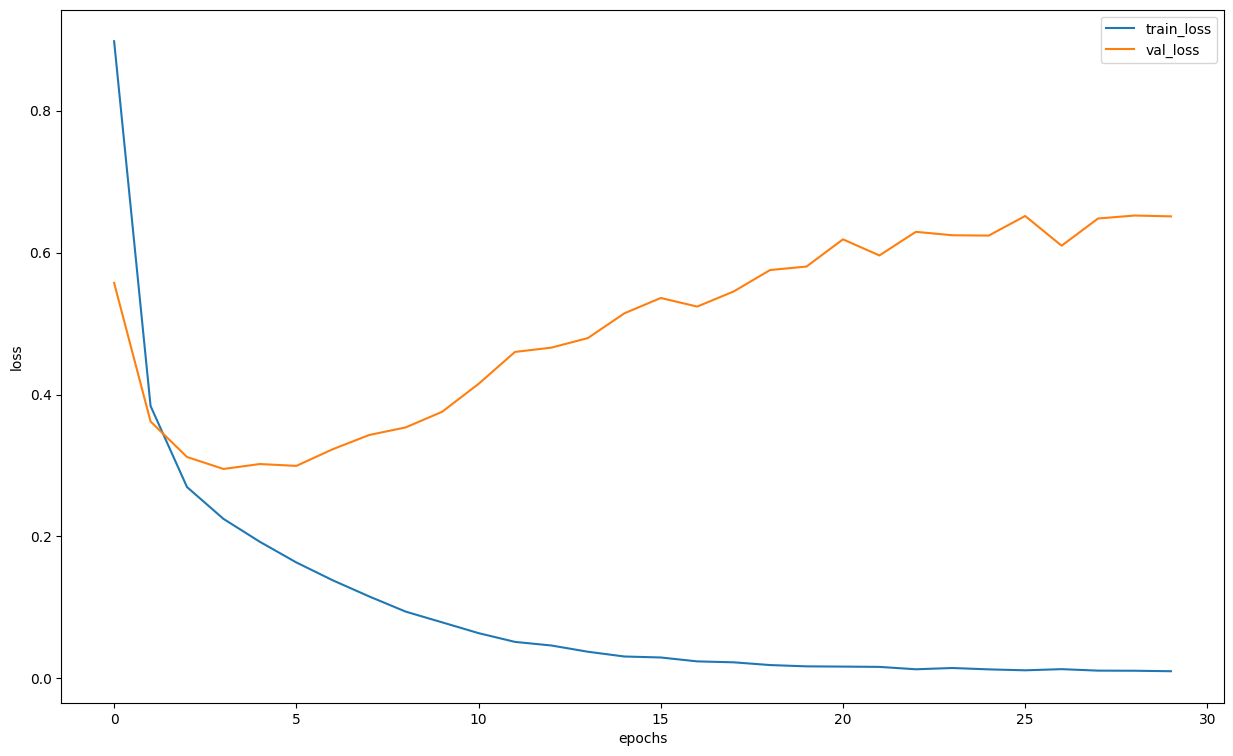

In [55]:
show_loss(gru_hist)

## EmbeddingBag + FC

In [30]:
from torch import nn


class EmbFCModel(nn.Module):
    def __init__(self,  embedding_dim, vocab_size, num_classes):
        super(EmbFCModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embedding_dim, sparse=False)
        self.fc = nn.Linear(embedding_dim, num_classes)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, input_batch):
        embedded = self.embedding(input_batch)
        return self.fc(embedded)

In [31]:
simple_classification = f"EmbFCModel_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

model = EmbFCModel(embedding_dim=100, 
                   vocab_size=len(vocab),
                   num_classes=4)
model.device = torch.device(device)
model = model.to(device)


criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters())
num_epochs = 30


tb_writer = SummaryWriter(f'models/runs/{exp_name}/board')

EmbFCModel = train(train_dataset=train_dataset, 
                   val_dataset=eval_dataset, 
                   model=model, 
                   epochs=num_epochs, 
                   optimizer=optimizer, 
                   criterion=criterion,
                   batch_size=256, 
                   tb_writer=tb_writer,
                   collate_fn=lambda x: collate_fn_with_padding(x, pad_id=word2ind['<pad>'], device=device),
                   model_dir=f'models/runs/{exp_name}')

train:   0%|          | 0/30 [00:00<?, ?it/s]

train:   3%|▎         | 1/30 [00:16<07:53, 16.34s/it]

Epoch 001 train_loss: 1.0521 val_loss 0.6733 train_acc 0.7527 val_acc 0.8544



train:   7%|▋         | 2/30 [00:32<07:35, 16.27s/it]

Epoch 002 train_loss: 0.5099 val_loss 0.4211 train_acc 0.8825 val_acc 0.8850



train:  10%|█         | 3/30 [00:48<07:18, 16.23s/it]

Epoch 003 train_loss: 0.3626 val_loss 0.3553 train_acc 0.9024 val_acc 0.8946



train:  13%|█▎        | 4/30 [01:04<07:01, 16.19s/it]

Epoch 004 train_loss: 0.3063 val_loss 0.3277 train_acc 0.9120 val_acc 0.9040



train:  17%|█▋        | 5/30 [01:20<06:43, 16.15s/it]

Epoch 005 train_loss: 0.2747 val_loss 0.3120 train_acc 0.9189 val_acc 0.9078



train:  20%|██        | 6/30 [01:36<06:24, 16.01s/it]

Epoch 006 train_loss: 0.2551 val_loss 0.3041 train_acc 0.9234 val_acc 0.9102



train:  23%|██▎       | 7/30 [01:52<06:09, 16.08s/it]

Epoch 007 train_loss: 0.2387 val_loss 0.2978 train_acc 0.9267 val_acc 0.9128



train:  27%|██▋       | 8/30 [02:09<05:55, 16.18s/it]

Epoch 008 train_loss: 0.2256 val_loss 0.2962 train_acc 0.9298 val_acc 0.9078



train:  30%|███       | 9/30 [02:25<05:41, 16.26s/it]

Epoch 009 train_loss: 0.2156 val_loss 0.2926 train_acc 0.9325 val_acc 0.9114



train:  33%|███▎      | 10/30 [02:42<05:25, 16.30s/it]

Epoch 010 train_loss: 0.2069 val_loss 0.2914 train_acc 0.9347 val_acc 0.9110



train:  37%|███▋      | 11/30 [02:58<05:10, 16.33s/it]

Epoch 011 train_loss: 0.1988 val_loss 0.2908 train_acc 0.9371 val_acc 0.9098



train:  40%|████      | 12/30 [03:14<04:54, 16.37s/it]

Epoch 012 train_loss: 0.1921 val_loss 0.2926 train_acc 0.9388 val_acc 0.9074



train:  43%|████▎     | 13/30 [03:31<04:38, 16.36s/it]

Epoch 013 train_loss: 0.1848 val_loss 0.2933 train_acc 0.9408 val_acc 0.9074



train:  47%|████▋     | 14/30 [03:47<04:21, 16.32s/it]

Epoch 014 train_loss: 0.1801 val_loss 0.2947 train_acc 0.9424 val_acc 0.9072



train:  50%|█████     | 15/30 [04:03<04:02, 16.18s/it]

Epoch 015 train_loss: 0.1751 val_loss 0.2946 train_acc 0.9439 val_acc 0.9100



train:  53%|█████▎    | 16/30 [04:19<03:44, 16.07s/it]

Epoch 016 train_loss: 0.1703 val_loss 0.2974 train_acc 0.9448 val_acc 0.9082



train:  57%|█████▋    | 17/30 [04:35<03:29, 16.11s/it]

Epoch 017 train_loss: 0.1655 val_loss 0.2988 train_acc 0.9464 val_acc 0.9112



train:  60%|██████    | 18/30 [04:51<03:13, 16.14s/it]

Epoch 018 train_loss: 0.1620 val_loss 0.3018 train_acc 0.9475 val_acc 0.9082



train:  63%|██████▎   | 19/30 [05:07<02:57, 16.10s/it]

Epoch 019 train_loss: 0.1583 val_loss 0.3046 train_acc 0.9485 val_acc 0.9064



train:  67%|██████▋   | 20/30 [05:24<02:41, 16.19s/it]

Epoch 020 train_loss: 0.1549 val_loss 0.3068 train_acc 0.9499 val_acc 0.9076



train:  70%|███████   | 21/30 [05:40<02:26, 16.24s/it]

Epoch 021 train_loss: 0.1519 val_loss 0.3087 train_acc 0.9505 val_acc 0.9064



train:  73%|███████▎  | 22/30 [05:56<02:10, 16.32s/it]

Epoch 022 train_loss: 0.1489 val_loss 0.3118 train_acc 0.9521 val_acc 0.9054



train:  77%|███████▋  | 23/30 [06:13<01:54, 16.33s/it]

Epoch 023 train_loss: 0.1455 val_loss 0.3138 train_acc 0.9525 val_acc 0.9062



train:  80%|████████  | 24/30 [06:29<01:37, 16.17s/it]

Epoch 024 train_loss: 0.1431 val_loss 0.3185 train_acc 0.9535 val_acc 0.9042



train:  83%|████████▎ | 25/30 [06:45<01:20, 16.15s/it]

Epoch 025 train_loss: 0.1401 val_loss 0.3225 train_acc 0.9539 val_acc 0.9030



train:  87%|████████▋ | 26/30 [07:00<01:04, 16.01s/it]

Epoch 026 train_loss: 0.1388 val_loss 0.3271 train_acc 0.9549 val_acc 0.9026



train:  90%|█████████ | 27/30 [07:16<00:47, 15.93s/it]

Epoch 027 train_loss: 0.1361 val_loss 0.3290 train_acc 0.9555 val_acc 0.9034



train:  93%|█████████▎| 28/30 [07:32<00:31, 15.93s/it]

Epoch 028 train_loss: 0.1339 val_loss 0.3337 train_acc 0.9564 val_acc 0.8996



train:  97%|█████████▋| 29/30 [07:48<00:15, 16.00s/it]

Epoch 029 train_loss: 0.1315 val_loss 0.3370 train_acc 0.9572 val_acc 0.8986



train: 100%|██████████| 30/30 [08:04<00:00, 16.16s/it]

Epoch 030 train_loss: 0.1300 val_loss 0.3390 train_acc 0.9576 val_acc 0.9004



In [32]:
exp_name

'SimpleGRU_SGD_lr0.01_20240328_193108'

## Подбор гиперпараметров

In [14]:
from src.models.architectures import SimpleRNN, SimpleLSTM, SimpleGRU

In [40]:
optimizers = {
    'SGD': torch.optim.SGD,
    'RMSprop': torch.optim.RMSprop
}

lrs = [10e-3, 10e-2, 10e-4]

In [25]:
models = {
    'SimpleRNN': SimpleRNN(hidden_dim=128,
                  vocab_size=len(vocab),
                  num_classes=4),
    'SimpleLSTM': SimpleLSTM(embedding_dim=100, 
                   hidden_dim=128,
                   vocab_size=len(vocab),
                   num_classes=4,
                   dropout_p=0.3,
                   n_layers=2),
    'SimpleGRU': SimpleGRU(embedding_dim=100, 
                   hidden_dim=128,
                   vocab_size=len(vocab),
                   num_classes=4,
                   n_layers=2)
}

In [42]:
import gc;

In [43]:
import copy

In [28]:
for model_name, model_cp in models.items():
    for opimizer_name, optimizer_fc in optimizers.items():
        for lr in lrs:
            if model_name ==  'SimpleRNN' and lr == 10e-3:
                continue

            exp_name = f"{model_name}_{opimizer_name}_lr{str(lr)}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
            print(exp_name)
            model = copy.deepcopy(model_cp)
            model.device = torch.device(device)
            model = model.to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optimizer_fc(model.parameters(), weight_decay=10e-4, lr=lr)
            num_epochs = 12
            batch_size = 256
            tb_writer = SummaryWriter(f'models/runs/{exp_name}/board')
            train(train_dataset=train_dataset, 
                val_dataset=eval_dataset, 
                model=model, 
                epochs=num_epochs, 
                optimizer=optimizer, 
                criterion=criterion,
                batch_size=batch_size, 
                tb_writer=tb_writer,
                collate_fn=lambda x: collate_fn_with_padding(x, pad_id=word2ind['<pad>'], device=device),
                model_dir=f'models/runs/{exp_name}')
            model.cpu()
            del model
            gc.collect()
            torch.cuda.empty_cache()

SimpleRNN_SGD_lr0.1_20240328_185401


train:   0%|          | 0/12 [00:00<?, ?it/s]

train:   8%|▊         | 1/12 [00:16<03:05, 16.82s/it]

Epoch 001 train_loss: 1.3791 val_loss 1.3676 train_acc 0.2933 val_acc 0.3500



train:  17%|█▋        | 2/12 [00:32<02:42, 16.23s/it]

Epoch 002 train_loss: 1.3446 val_loss 1.2987 train_acc 0.3643 val_acc 0.4006



train:  25%|██▌       | 3/12 [00:48<02:24, 16.08s/it]

Epoch 003 train_loss: 1.2895 val_loss 1.2208 train_acc 0.4089 val_acc 0.4814



train:  33%|███▎      | 4/12 [01:04<02:08, 16.02s/it]

Epoch 004 train_loss: 1.2342 val_loss 1.1606 train_acc 0.4545 val_acc 0.4998



train:  42%|████▏     | 5/12 [01:20<01:51, 15.95s/it]

Epoch 005 train_loss: 1.1747 val_loss 1.0860 train_acc 0.4932 val_acc 0.5652



train:  50%|█████     | 6/12 [01:36<01:35, 15.92s/it]

Epoch 006 train_loss: 1.1174 val_loss 1.0560 train_acc 0.5305 val_acc 0.5646



train:  58%|█████▊    | 7/12 [01:52<01:19, 15.90s/it]

Epoch 007 train_loss: 1.0608 val_loss 1.0361 train_acc 0.5598 val_acc 0.5678



train:  67%|██████▋   | 8/12 [02:07<01:03, 15.86s/it]

Epoch 008 train_loss: 1.0034 val_loss 0.9656 train_acc 0.5908 val_acc 0.6056



train:  75%|███████▌  | 9/12 [02:23<00:47, 15.86s/it]

Epoch 009 train_loss: 0.9498 val_loss 0.9719 train_acc 0.6202 val_acc 0.6070



train:  83%|████████▎ | 10/12 [02:39<00:31, 15.94s/it]

Epoch 010 train_loss: 0.9266 val_loss 0.8581 train_acc 0.6373 val_acc 0.6616



train:  92%|█████████▏| 11/12 [02:56<00:16, 16.06s/it]

Epoch 011 train_loss: 1.2131 val_loss 1.0996 train_acc 0.5215 val_acc 0.5624



train: 100%|██████████| 12/12 [03:12<00:00, 16.04s/it]


Epoch 012 train_loss: 1.1372 val_loss 0.9665 train_acc 0.5371 val_acc 0.6344

SimpleRNN_SGD_lr0.001_20240328_185713


train:   8%|▊         | 1/12 [00:16<03:05, 16.85s/it]

Epoch 001 train_loss: 1.3896 val_loss 1.3863 train_acc 0.2496 val_acc 0.2566



train:  17%|█▋        | 2/12 [00:33<02:47, 16.74s/it]

Epoch 002 train_loss: 1.3869 val_loss 1.3860 train_acc 0.2476 val_acc 0.2442



train:  25%|██▌       | 3/12 [00:50<02:30, 16.67s/it]

Epoch 003 train_loss: 1.3865 val_loss 1.3859 train_acc 0.2507 val_acc 0.2492



train:  33%|███▎      | 4/12 [01:06<02:13, 16.67s/it]

Epoch 004 train_loss: 1.3863 val_loss 1.3857 train_acc 0.2535 val_acc 0.2524



train:  42%|████▏     | 5/12 [01:23<01:56, 16.67s/it]

Epoch 005 train_loss: 1.3861 val_loss 1.3855 train_acc 0.2541 val_acc 0.2534



train:  50%|█████     | 6/12 [01:40<01:39, 16.66s/it]

Epoch 006 train_loss: 1.3859 val_loss 1.3854 train_acc 0.2566 val_acc 0.2586



train:  58%|█████▊    | 7/12 [01:56<01:23, 16.65s/it]

Epoch 007 train_loss: 1.3857 val_loss 1.3852 train_acc 0.2587 val_acc 0.2594



train:  67%|██████▋   | 8/12 [02:13<01:06, 16.66s/it]

Epoch 008 train_loss: 1.3855 val_loss 1.3850 train_acc 0.2611 val_acc 0.2656



train:  75%|███████▌  | 9/12 [02:29<00:49, 16.63s/it]

Epoch 009 train_loss: 1.3856 val_loss 1.3848 train_acc 0.2592 val_acc 0.2700



train:  83%|████████▎ | 10/12 [02:46<00:33, 16.63s/it]

Epoch 010 train_loss: 1.3851 val_loss 1.3847 train_acc 0.2648 val_acc 0.2748



train:  92%|█████████▏| 11/12 [03:03<00:16, 16.63s/it]

Epoch 011 train_loss: 1.3850 val_loss 1.3845 train_acc 0.2670 val_acc 0.2770



train: 100%|██████████| 12/12 [03:19<00:00, 16.65s/it]


Epoch 012 train_loss: 1.3848 val_loss 1.3843 train_acc 0.2699 val_acc 0.2752

SimpleRNN_RMSprop_lr0.1_20240328_190033


train:   8%|▊         | 1/12 [00:16<03:05, 16.82s/it]

Epoch 001 train_loss: nan val_loss nan train_acc 0.2502 val_acc 0.2470



train:  17%|█▋        | 2/12 [00:33<02:47, 16.76s/it]

Epoch 002 train_loss: nan val_loss nan train_acc 0.2500 val_acc 0.2470



train:  25%|██▌       | 3/12 [00:50<02:31, 16.80s/it]

Epoch 003 train_loss: nan val_loss nan train_acc 0.2500 val_acc 0.2470



train:  33%|███▎      | 4/12 [01:07<02:15, 16.89s/it]

Epoch 004 train_loss: nan val_loss nan train_acc 0.2500 val_acc 0.2470



train:  42%|████▏     | 5/12 [01:24<01:58, 16.93s/it]

Epoch 005 train_loss: nan val_loss nan train_acc 0.2500 val_acc 0.2470



train:  50%|█████     | 6/12 [01:41<01:41, 16.92s/it]

Epoch 006 train_loss: nan val_loss nan train_acc 0.2500 val_acc 0.2470



train:  58%|█████▊    | 7/12 [01:58<01:24, 16.92s/it]

Epoch 007 train_loss: nan val_loss nan train_acc 0.2500 val_acc 0.2470



train:  67%|██████▋   | 8/12 [02:15<01:07, 16.94s/it]

Epoch 008 train_loss: nan val_loss nan train_acc 0.2500 val_acc 0.2470



train:  75%|███████▌  | 9/12 [02:32<00:50, 16.97s/it]

Epoch 009 train_loss: nan val_loss nan train_acc 0.2500 val_acc 0.2470



train:  83%|████████▎ | 10/12 [02:49<00:33, 16.94s/it]

Epoch 010 train_loss: nan val_loss nan train_acc 0.2500 val_acc 0.2470



train:  92%|█████████▏| 11/12 [03:05<00:16, 16.84s/it]

Epoch 011 train_loss: nan val_loss nan train_acc 0.2500 val_acc 0.2470



train: 100%|██████████| 12/12 [03:22<00:00, 16.86s/it]


Epoch 012 train_loss: nan val_loss nan train_acc 0.2500 val_acc 0.2470

SimpleRNN_RMSprop_lr0.001_20240328_190356


train:   8%|▊         | 1/12 [00:16<03:04, 16.75s/it]

Epoch 001 train_loss: 1.2038 val_loss 1.0244 train_acc 0.4563 val_acc 0.5850



train:  17%|█▋        | 2/12 [00:33<02:46, 16.61s/it]

Epoch 002 train_loss: 0.8329 val_loss 0.6808 train_acc 0.6810 val_acc 0.7498



train:  25%|██▌       | 3/12 [00:49<02:29, 16.61s/it]

Epoch 003 train_loss: 0.6576 val_loss 0.5196 train_acc 0.7703 val_acc 0.8192



train:  33%|███▎      | 4/12 [01:06<02:13, 16.68s/it]

Epoch 004 train_loss: 0.6042 val_loss 0.4978 train_acc 0.8042 val_acc 0.8210



train:  42%|████▏     | 5/12 [01:23<01:56, 16.68s/it]

Epoch 005 train_loss: 0.5257 val_loss 0.4105 train_acc 0.8364 val_acc 0.8724



train:  50%|█████     | 6/12 [01:40<01:40, 16.72s/it]

Epoch 006 train_loss: 0.5447 val_loss 0.4930 train_acc 0.8375 val_acc 0.8296



train:  58%|█████▊    | 7/12 [01:56<01:23, 16.73s/it]

Epoch 007 train_loss: 0.4639 val_loss 0.4595 train_acc 0.8548 val_acc 0.8386



train:  67%|██████▋   | 8/12 [02:13<01:06, 16.70s/it]

Epoch 008 train_loss: 0.5362 val_loss 0.5142 train_acc 0.8437 val_acc 0.8208



train:  75%|███████▌  | 9/12 [02:30<00:50, 16.74s/it]

Epoch 009 train_loss: 0.4916 val_loss 0.4003 train_acc 0.8511 val_acc 0.8754



train:  83%|████████▎ | 10/12 [02:47<00:33, 16.77s/it]

Epoch 010 train_loss: 0.4477 val_loss 0.3852 train_acc 0.8633 val_acc 0.8786



train:  92%|█████████▏| 11/12 [03:04<00:16, 16.81s/it]

Epoch 011 train_loss: 0.4939 val_loss 0.3911 train_acc 0.8575 val_acc 0.8772



train: 100%|██████████| 12/12 [03:20<00:00, 16.75s/it]


Epoch 012 train_loss: 0.3945 val_loss 0.3880 train_acc 0.8740 val_acc 0.8744

SimpleLSTM_SGD_lr0.01_20240328_190717


train:   8%|▊         | 1/12 [00:20<03:40, 20.07s/it]

Epoch 001 train_loss: 1.3864 val_loss 1.3865 train_acc 0.2499 val_acc 0.2394



train:  17%|█▋        | 2/12 [00:40<03:20, 20.03s/it]

Epoch 002 train_loss: 1.3863 val_loss 1.3864 train_acc 0.2494 val_acc 0.2394



train:  25%|██▌       | 3/12 [01:00<03:00, 20.06s/it]

Epoch 003 train_loss: 1.3863 val_loss 1.3864 train_acc 0.2498 val_acc 0.2394



train:  33%|███▎      | 4/12 [01:20<02:40, 20.12s/it]

Epoch 004 train_loss: 1.3863 val_loss 1.3864 train_acc 0.2506 val_acc 0.2394



train:  42%|████▏     | 5/12 [01:40<02:20, 20.11s/it]

Epoch 005 train_loss: 1.3863 val_loss 1.3864 train_acc 0.2506 val_acc 0.2394



train:  50%|█████     | 6/12 [02:00<02:01, 20.17s/it]

Epoch 006 train_loss: 1.3863 val_loss 1.3864 train_acc 0.2489 val_acc 0.2394



train:  58%|█████▊    | 7/12 [02:21<01:40, 20.19s/it]

Epoch 007 train_loss: 1.3863 val_loss 1.3864 train_acc 0.2491 val_acc 0.2394



train:  67%|██████▋   | 8/12 [02:41<01:20, 20.17s/it]

Epoch 008 train_loss: 1.3863 val_loss 1.3864 train_acc 0.2490 val_acc 0.2394



train:  75%|███████▌  | 9/12 [03:01<01:00, 20.10s/it]

Epoch 009 train_loss: 1.3863 val_loss 1.3864 train_acc 0.2511 val_acc 0.2394



train:  83%|████████▎ | 10/12 [03:21<00:40, 20.06s/it]

Epoch 010 train_loss: 1.3863 val_loss 1.3863 train_acc 0.2474 val_acc 0.2394



train:  92%|█████████▏| 11/12 [03:40<00:19, 19.92s/it]

Epoch 011 train_loss: 1.3863 val_loss 1.3863 train_acc 0.2495 val_acc 0.2394



train: 100%|██████████| 12/12 [04:00<00:00, 20.05s/it]


Epoch 012 train_loss: 1.3863 val_loss 1.3863 train_acc 0.2492 val_acc 0.2394

SimpleLSTM_SGD_lr0.1_20240328_191117


train:   8%|▊         | 1/12 [00:20<03:40, 20.02s/it]

Epoch 001 train_loss: 1.3863 val_loss 1.3864 train_acc 0.2496 val_acc 0.2394



train:  17%|█▋        | 2/12 [00:39<03:18, 19.87s/it]

Epoch 002 train_loss: 1.3863 val_loss 1.3863 train_acc 0.2477 val_acc 0.2394



train:  25%|██▌       | 3/12 [00:59<02:57, 19.74s/it]

Epoch 003 train_loss: 1.3863 val_loss 1.3863 train_acc 0.2490 val_acc 0.2394



train:  33%|███▎      | 4/12 [01:19<02:39, 19.90s/it]

Epoch 004 train_loss: 1.3863 val_loss 1.3863 train_acc 0.2484 val_acc 0.2556



train:  42%|████▏     | 5/12 [01:39<02:19, 19.89s/it]

Epoch 005 train_loss: 1.3863 val_loss 1.3863 train_acc 0.2501 val_acc 0.2588



train:  50%|█████     | 6/12 [01:59<01:59, 19.87s/it]

Epoch 006 train_loss: 1.3863 val_loss 1.3863 train_acc 0.2506 val_acc 0.2478



train:  58%|█████▊    | 7/12 [02:19<01:39, 19.94s/it]

Epoch 007 train_loss: 1.3863 val_loss 1.3863 train_acc 0.2513 val_acc 0.2410



train:  67%|██████▋   | 8/12 [02:39<01:19, 19.90s/it]

Epoch 008 train_loss: 1.3863 val_loss 1.3863 train_acc 0.2484 val_acc 0.2410



train:  75%|███████▌  | 9/12 [02:58<00:59, 19.81s/it]

Epoch 009 train_loss: 1.3863 val_loss 1.3863 train_acc 0.2498 val_acc 0.2592



train:  83%|████████▎ | 10/12 [03:18<00:39, 19.81s/it]

Epoch 010 train_loss: 1.3863 val_loss 1.3863 train_acc 0.2498 val_acc 0.2598



train:  92%|█████████▏| 11/12 [03:38<00:19, 19.75s/it]

Epoch 011 train_loss: 1.3863 val_loss 1.3863 train_acc 0.2495 val_acc 0.2484



train: 100%|██████████| 12/12 [03:58<00:00, 19.88s/it]


Epoch 012 train_loss: 1.3863 val_loss 1.3863 train_acc 0.2498 val_acc 0.2412

SimpleLSTM_SGD_lr0.001_20240328_191516


train:   8%|▊         | 1/12 [00:20<03:42, 20.23s/it]

Epoch 001 train_loss: 1.3863 val_loss 1.3865 train_acc 0.2499 val_acc 0.2394



train:  17%|█▋        | 2/12 [00:40<03:21, 20.13s/it]

Epoch 002 train_loss: 1.3863 val_loss 1.3865 train_acc 0.2500 val_acc 0.2394



train:  25%|██▌       | 3/12 [01:00<03:00, 20.06s/it]

Epoch 003 train_loss: 1.3863 val_loss 1.3865 train_acc 0.2498 val_acc 0.2394



train:  33%|███▎      | 4/12 [01:20<02:40, 20.00s/it]

Epoch 004 train_loss: 1.3863 val_loss 1.3865 train_acc 0.2502 val_acc 0.2394



train:  42%|████▏     | 5/12 [01:40<02:19, 19.97s/it]

Epoch 005 train_loss: 1.3863 val_loss 1.3865 train_acc 0.2503 val_acc 0.2394



train:  50%|█████     | 6/12 [01:59<01:59, 19.94s/it]

Epoch 006 train_loss: 1.3863 val_loss 1.3865 train_acc 0.2504 val_acc 0.2394



train:  58%|█████▊    | 7/12 [02:20<01:39, 19.97s/it]

Epoch 007 train_loss: 1.3863 val_loss 1.3865 train_acc 0.2504 val_acc 0.2394



train:  67%|██████▋   | 8/12 [02:39<01:19, 19.89s/it]

Epoch 008 train_loss: 1.3863 val_loss 1.3865 train_acc 0.2503 val_acc 0.2394



train:  75%|███████▌  | 9/12 [02:59<00:59, 19.82s/it]

Epoch 009 train_loss: 1.3863 val_loss 1.3865 train_acc 0.2500 val_acc 0.2394



train:  83%|████████▎ | 10/12 [03:19<00:39, 19.86s/it]

Epoch 010 train_loss: 1.3863 val_loss 1.3865 train_acc 0.2504 val_acc 0.2394



train:  92%|█████████▏| 11/12 [03:39<00:19, 19.92s/it]

Epoch 011 train_loss: 1.3863 val_loss 1.3865 train_acc 0.2498 val_acc 0.2394



train: 100%|██████████| 12/12 [03:59<00:00, 19.94s/it]


Epoch 012 train_loss: 1.3863 val_loss 1.3865 train_acc 0.2497 val_acc 0.2394

SimpleLSTM_RMSprop_lr0.01_20240328_191915


train:   8%|▊         | 1/12 [00:20<03:41, 20.13s/it]

Epoch 001 train_loss: 1.3875 val_loss 1.3863 train_acc 0.2509 val_acc 0.2568



train:  17%|█▋        | 2/12 [00:40<03:19, 19.99s/it]

Epoch 002 train_loss: 1.3869 val_loss 1.3862 train_acc 0.2497 val_acc 0.2470



train:  25%|██▌       | 3/12 [01:00<03:00, 20.02s/it]

Epoch 003 train_loss: 1.3871 val_loss 1.3863 train_acc 0.2505 val_acc 0.2470



train:  33%|███▎      | 4/12 [01:19<02:39, 19.89s/it]

Epoch 004 train_loss: 1.3866 val_loss 1.3863 train_acc 0.2465 val_acc 0.2568



train:  42%|████▏     | 5/12 [01:39<02:18, 19.72s/it]

Epoch 005 train_loss: 1.3871 val_loss 1.3868 train_acc 0.2502 val_acc 0.2470



train:  50%|█████     | 6/12 [01:58<01:58, 19.72s/it]

Epoch 006 train_loss: 1.3865 val_loss 1.3866 train_acc 0.2482 val_acc 0.2394



train:  58%|█████▊    | 7/12 [02:18<01:39, 19.81s/it]

Epoch 007 train_loss: 1.3865 val_loss 1.3867 train_acc 0.2489 val_acc 0.2394



train:  67%|██████▋   | 8/12 [02:38<01:19, 19.88s/it]

Epoch 008 train_loss: 1.3865 val_loss 1.3862 train_acc 0.2515 val_acc 0.2470



train:  75%|███████▌  | 9/12 [02:59<00:59, 19.99s/it]

Epoch 009 train_loss: 1.3871 val_loss 1.3864 train_acc 0.2509 val_acc 0.2470



train:  83%|████████▎ | 10/12 [03:19<00:39, 19.98s/it]

Epoch 010 train_loss: 1.3870 val_loss 1.3863 train_acc 0.2490 val_acc 0.2568



train:  92%|█████████▏| 11/12 [03:39<00:19, 19.98s/it]

Epoch 011 train_loss: 1.3866 val_loss 1.3862 train_acc 0.2505 val_acc 0.2568



train: 100%|██████████| 12/12 [03:59<00:00, 19.92s/it]


Epoch 012 train_loss: 1.3864 val_loss 1.3866 train_acc 0.2496 val_acc 0.2470

SimpleLSTM_RMSprop_lr0.1_20240328_192315


train:   8%|▊         | 1/12 [00:20<03:44, 20.41s/it]

Epoch 001 train_loss: 1.3891 val_loss 1.3866 train_acc 0.2500 val_acc 0.2396



train:  17%|█▋        | 2/12 [00:40<03:23, 20.31s/it]

Epoch 002 train_loss: 1.3884 val_loss 1.3874 train_acc 0.2501 val_acc 0.2580



train:  25%|██▌       | 3/12 [01:01<03:02, 20.33s/it]

Epoch 003 train_loss: 1.3887 val_loss 1.3863 train_acc 0.2500 val_acc 0.2464



train:  33%|███▎      | 4/12 [01:20<02:41, 20.16s/it]

Epoch 004 train_loss: nan val_loss nan train_acc 0.2490 val_acc 0.2470



train:  42%|████▏     | 5/12 [01:40<02:20, 20.01s/it]

Epoch 005 train_loss: nan val_loss nan train_acc 0.2500 val_acc 0.2470



train:  50%|█████     | 6/12 [02:00<01:59, 19.94s/it]

Epoch 006 train_loss: nan val_loss nan train_acc 0.2500 val_acc 0.2470



train:  58%|█████▊    | 7/12 [02:20<01:39, 19.93s/it]

Epoch 007 train_loss: nan val_loss nan train_acc 0.2500 val_acc 0.2470



train:  67%|██████▋   | 8/12 [02:40<01:19, 19.96s/it]

Epoch 008 train_loss: nan val_loss nan train_acc 0.2500 val_acc 0.2470



train:  75%|███████▌  | 9/12 [03:00<00:59, 19.89s/it]

Epoch 009 train_loss: nan val_loss nan train_acc 0.2500 val_acc 0.2470



train:  83%|████████▎ | 10/12 [03:19<00:39, 19.88s/it]

Epoch 010 train_loss: nan val_loss nan train_acc 0.2500 val_acc 0.2470



train:  92%|█████████▏| 11/12 [03:39<00:19, 19.87s/it]

Epoch 011 train_loss: nan val_loss nan train_acc 0.2500 val_acc 0.2470



train: 100%|██████████| 12/12 [03:59<00:00, 19.99s/it]


Epoch 012 train_loss: nan val_loss nan train_acc 0.2500 val_acc 0.2470

SimpleLSTM_RMSprop_lr0.001_20240328_192715


train:   8%|▊         | 1/12 [00:19<03:38, 19.87s/it]

Epoch 001 train_loss: 1.3864 val_loss 1.3864 train_acc 0.2494 val_acc 0.2394



train:  17%|█▋        | 2/12 [00:39<03:19, 19.99s/it]

Epoch 002 train_loss: 1.3863 val_loss 1.3863 train_acc 0.2496 val_acc 0.2470



train:  25%|██▌       | 3/12 [00:59<02:58, 19.80s/it]

Epoch 003 train_loss: 1.3863 val_loss 1.3863 train_acc 0.2492 val_acc 0.2568



train:  33%|███▎      | 4/12 [01:18<02:37, 19.66s/it]

Epoch 004 train_loss: 1.3863 val_loss 1.3863 train_acc 0.2501 val_acc 0.2394



train:  42%|████▏     | 5/12 [01:38<02:17, 19.61s/it]

Epoch 005 train_loss: 1.3863 val_loss 1.3863 train_acc 0.2482 val_acc 0.2568



train:  50%|█████     | 6/12 [01:58<01:58, 19.74s/it]

Epoch 006 train_loss: 1.3863 val_loss 1.3863 train_acc 0.2494 val_acc 0.2568



train:  58%|█████▊    | 7/12 [02:18<01:39, 19.81s/it]

Epoch 007 train_loss: 1.3863 val_loss 1.3863 train_acc 0.2488 val_acc 0.2568



train:  67%|██████▋   | 8/12 [02:37<01:18, 19.57s/it]

Epoch 008 train_loss: 1.3863 val_loss 1.3863 train_acc 0.2490 val_acc 0.2568



train:  75%|███████▌  | 9/12 [02:56<00:58, 19.37s/it]

Epoch 009 train_loss: 1.3863 val_loss 1.3863 train_acc 0.2473 val_acc 0.2470



train:  83%|████████▎ | 10/12 [03:15<00:38, 19.24s/it]

Epoch 010 train_loss: 1.3863 val_loss 1.3863 train_acc 0.2488 val_acc 0.2470



train:  92%|█████████▏| 11/12 [03:34<00:19, 19.12s/it]

Epoch 011 train_loss: 1.3863 val_loss 1.3863 train_acc 0.2483 val_acc 0.2470



train: 100%|██████████| 12/12 [03:53<00:00, 19.47s/it]


Epoch 012 train_loss: 1.3863 val_loss 1.3863 train_acc 0.2483 val_acc 0.2470

SimpleGRU_SGD_lr0.01_20240328_193108


train:   0%|          | 0/12 [00:00<?, ?it/s]


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/vlad/miniconda3/envs/py10yolo/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_110166/3564410371.py", line 17, in <module>
    train(train_dataset=train_dataset,
  File "/media/vlad/hard/Study/nn/news-classification/src/models/train_model.py", line 66, in train
    train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer, scheduler=scheduler)
  File "/media/vlad/hard/Study/nn/news-classification/src/models/train_model.py", line 19, in fit_epoch
    outputs = model(inputs)
  File "/home/vlad/miniconda3/envs/py10yolo/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1511, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/vlad/miniconda3/envs/py10yolo/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1520, in _call_impl
    return forward_call(*args, **k

In [45]:
model_cp = SimpleGRU(embedding_dim=100, 
                   hidden_dim=128,
                   vocab_size=len(vocab),
                   num_classes=4,
                   n_layers=2)
for opimizer_name, optimizer_fc in optimizers.items():
        exp_name = f"{model_name}_{opimizer_name}_lr{str(lr)}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
        print(exp_name)
        model = copy.deepcopy(model_cp)
        model.device = torch.device(device)
        model = model.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optimizer_fc(model.parameters(), weight_decay=10e-4, lr=lr)
        num_epochs = 12
        batch_size = 256
        tb_writer = SummaryWriter(f'models/runs/{exp_name}/board')
        train(train_dataset=train_dataset, 
            val_dataset=eval_dataset, 
            model=model, 
            epochs=num_epochs, 
            optimizer=optimizer, 
            criterion=criterion,
            batch_size=batch_size, 
            tb_writer=tb_writer,
            collate_fn=lambda x: collate_fn_with_padding(x, pad_id=word2ind['<pad>'], device=device),
            model_dir=f'models/runs/{exp_name}')
        model.cpu()
        del model
        gc.collect()
        torch.cuda.empty_cache()

SimpleRNN_SGD_lr0.1_20240328_201837


train:   8%|▊         | 1/12 [00:19<03:34, 19.46s/it]

Epoch 001 train_loss: 1.3884 val_loss 1.3862 train_acc 0.2500 val_acc 0.2568



train:  17%|█▋        | 2/12 [00:38<03:12, 19.21s/it]

Epoch 002 train_loss: 1.3867 val_loss 1.3873 train_acc 0.2525 val_acc 0.2484



train:  25%|██▌       | 3/12 [00:57<02:51, 19.05s/it]

Epoch 003 train_loss: 1.3863 val_loss 1.3862 train_acc 0.2502 val_acc 0.2484



train:  33%|███▎      | 4/12 [01:16<02:32, 19.09s/it]

Epoch 004 train_loss: 1.3861 val_loss 1.3864 train_acc 0.2528 val_acc 0.2484



train:  42%|████▏     | 5/12 [01:35<02:13, 19.07s/it]

Epoch 005 train_loss: 1.3860 val_loss 1.3857 train_acc 0.2499 val_acc 0.2414



train:  50%|█████     | 6/12 [01:54<01:54, 19.02s/it]

Epoch 006 train_loss: 1.3859 val_loss 1.3862 train_acc 0.2509 val_acc 0.2592



train:  58%|█████▊    | 7/12 [02:13<01:34, 18.98s/it]

Epoch 007 train_loss: 1.3859 val_loss 1.3862 train_acc 0.2511 val_acc 0.2412



train:  67%|██████▋   | 8/12 [02:32<01:15, 18.94s/it]

Epoch 008 train_loss: 1.3859 val_loss 1.3859 train_acc 0.2508 val_acc 0.2568



train:  75%|███████▌  | 9/12 [02:51<00:56, 19.00s/it]

Epoch 009 train_loss: 1.3859 val_loss 1.3856 train_acc 0.2515 val_acc 0.2592



train:  83%|████████▎ | 10/12 [03:10<00:37, 18.99s/it]

Epoch 010 train_loss: 1.3858 val_loss 1.3856 train_acc 0.2489 val_acc 0.2598



train:  92%|█████████▏| 11/12 [03:29<00:18, 18.95s/it]

Epoch 011 train_loss: 1.3858 val_loss 1.3854 train_acc 0.2515 val_acc 0.2598



train: 100%|██████████| 12/12 [03:48<00:00, 19.01s/it]


Epoch 012 train_loss: 1.3858 val_loss 1.3857 train_acc 0.2530 val_acc 0.2592

SimpleRNN_SGD_lr0.001_20240328_202226


train:   8%|▊         | 1/12 [00:19<03:31, 19.19s/it]

Epoch 001 train_loss: 1.3877 val_loss 1.3864 train_acc 0.2484 val_acc 0.2398



train:  17%|█▋        | 2/12 [00:38<03:11, 19.13s/it]

Epoch 002 train_loss: 1.3866 val_loss 1.3862 train_acc 0.2503 val_acc 0.2550



train:  25%|██▌       | 3/12 [00:57<02:51, 19.06s/it]

Epoch 003 train_loss: 1.3867 val_loss 1.3863 train_acc 0.2473 val_acc 0.2574



train:  33%|███▎      | 4/12 [01:16<02:32, 19.05s/it]

Epoch 004 train_loss: 1.3866 val_loss 1.3864 train_acc 0.2500 val_acc 0.2394



train:  42%|████▏     | 5/12 [01:35<02:13, 19.02s/it]

Epoch 005 train_loss: 1.3866 val_loss 1.3864 train_acc 0.2495 val_acc 0.2574



train:  50%|█████     | 6/12 [01:54<01:53, 18.99s/it]

Epoch 006 train_loss: 1.3866 val_loss 1.3864 train_acc 0.2496 val_acc 0.2396



train:  58%|█████▊    | 7/12 [02:13<01:34, 18.99s/it]

Epoch 007 train_loss: 1.3866 val_loss 1.3863 train_acc 0.2500 val_acc 0.2570



train:  67%|██████▋   | 8/12 [02:32<01:16, 19.05s/it]

Epoch 008 train_loss: 1.3865 val_loss 1.3863 train_acc 0.2510 val_acc 0.2394



train:  75%|███████▌  | 9/12 [02:51<00:56, 18.94s/it]

Epoch 009 train_loss: 1.3866 val_loss 1.3865 train_acc 0.2492 val_acc 0.2444



train:  83%|████████▎ | 10/12 [03:09<00:37, 18.94s/it]

Epoch 010 train_loss: 1.3866 val_loss 1.3863 train_acc 0.2510 val_acc 0.2576



train:  92%|█████████▏| 11/12 [03:29<00:19, 19.03s/it]

Epoch 011 train_loss: 1.3866 val_loss 1.3864 train_acc 0.2495 val_acc 0.2396



train: 100%|██████████| 12/12 [03:48<00:00, 19.03s/it]


Epoch 012 train_loss: 1.3865 val_loss 1.3863 train_acc 0.2494 val_acc 0.2460

SimpleRNN_RMSprop_lr0.1_20240328_202614


train:   8%|▊         | 1/12 [00:19<03:30, 19.18s/it]

Epoch 001 train_loss: 9.3948 val_loss 7.8636 train_acc 0.2509 val_acc 0.2516



train:  17%|█▋        | 2/12 [00:38<03:14, 19.46s/it]

Epoch 002 train_loss: 7.5510 val_loss 2.0387 train_acc 0.2515 val_acc 0.2500



train:  25%|██▌       | 3/12 [00:58<02:55, 19.47s/it]

Epoch 003 train_loss: 7.3802 val_loss 7.8806 train_acc 0.2526 val_acc 0.2568



train:  33%|███▎      | 4/12 [01:17<02:35, 19.42s/it]

Epoch 004 train_loss: 7.6869 val_loss 4.1303 train_acc 0.2530 val_acc 0.2466



train:  42%|████▏     | 5/12 [01:37<02:16, 19.43s/it]

Epoch 005 train_loss: 7.4068 val_loss 5.0377 train_acc 0.2530 val_acc 0.2412



train:  50%|█████     | 6/12 [01:56<01:56, 19.36s/it]

Epoch 006 train_loss: 7.7127 val_loss 8.6883 train_acc 0.2516 val_acc 0.2474



train:  58%|█████▊    | 7/12 [02:15<01:36, 19.36s/it]

Epoch 007 train_loss: 7.8924 val_loss 7.1979 train_acc 0.2526 val_acc 0.2622



train:  67%|██████▋   | 8/12 [02:34<01:17, 19.31s/it]

Epoch 008 train_loss: 7.6365 val_loss 7.8954 train_acc 0.2533 val_acc 0.2468



train:  75%|███████▌  | 9/12 [02:54<00:57, 19.29s/it]

Epoch 009 train_loss: 7.6034 val_loss 3.0595 train_acc 0.2528 val_acc 0.2482



train:  83%|████████▎ | 10/12 [03:13<00:38, 19.32s/it]

Epoch 010 train_loss: 8.0504 val_loss 8.8454 train_acc 0.2530 val_acc 0.2470



train:  92%|█████████▏| 11/12 [03:32<00:19, 19.29s/it]

Epoch 011 train_loss: 7.6095 val_loss 6.0238 train_acc 0.2530 val_acc 0.2570



train: 100%|██████████| 12/12 [03:52<00:00, 19.34s/it]


Epoch 012 train_loss: 7.1116 val_loss 6.2828 train_acc 0.2527 val_acc 0.2452

SimpleRNN_RMSprop_lr0.001_20240328_203007


train:   8%|▊         | 1/12 [00:19<03:31, 19.23s/it]

Epoch 001 train_loss: 1.1900 val_loss 0.9893 train_acc 0.4105 val_acc 0.5386



train:  17%|█▋        | 2/12 [00:38<03:11, 19.18s/it]

Epoch 002 train_loss: 0.8192 val_loss 0.6341 train_acc 0.6553 val_acc 0.7716



train:  25%|██▌       | 3/12 [00:57<02:52, 19.18s/it]

Epoch 003 train_loss: 0.5183 val_loss 0.4698 train_acc 0.8189 val_acc 0.8402



train:  33%|███▎      | 4/12 [01:16<02:33, 19.20s/it]

Epoch 004 train_loss: 0.4162 val_loss 0.3914 train_acc 0.8608 val_acc 0.8760



train:  42%|████▏     | 5/12 [01:35<02:14, 19.17s/it]

Epoch 005 train_loss: 0.3540 val_loss 0.4076 train_acc 0.8841 val_acc 0.8682



train:  50%|█████     | 6/12 [01:55<01:55, 19.17s/it]

Epoch 006 train_loss: 0.3313 val_loss 0.3919 train_acc 0.8936 val_acc 0.8708



train:  58%|█████▊    | 7/12 [02:14<01:35, 19.20s/it]

Epoch 007 train_loss: 0.3171 val_loss 0.3705 train_acc 0.8973 val_acc 0.8766



train:  67%|██████▋   | 8/12 [02:33<01:16, 19.22s/it]

Epoch 008 train_loss: 0.3046 val_loss 0.3740 train_acc 0.9029 val_acc 0.8822



train:  75%|███████▌  | 9/12 [02:52<00:57, 19.21s/it]

Epoch 009 train_loss: 0.2986 val_loss 0.3197 train_acc 0.9039 val_acc 0.9030



train:  83%|████████▎ | 10/12 [03:11<00:38, 19.18s/it]

Epoch 010 train_loss: 0.2935 val_loss 0.3194 train_acc 0.9044 val_acc 0.8986



train:  92%|█████████▏| 11/12 [03:31<00:19, 19.19s/it]

Epoch 011 train_loss: 0.2860 val_loss 0.3025 train_acc 0.9075 val_acc 0.9008



train: 100%|██████████| 12/12 [03:50<00:00, 19.19s/it]

Epoch 012 train_loss: 0.2778 val_loss 0.3140 train_acc 0.9090 val_acc 0.8946



## Экспорт лучших моделей

In [14]:
from src.models.export import export_to_onnx

In [15]:
from src.models.architectures import SimpleRNN, SimpleLSTM, SimpleGRU, EmbFCModel

In [16]:
models = {
    'SimpleRNN': SimpleRNN(hidden_dim=128,
                  vocab_size=len(vocab),
                  num_classes=4),
    'SimpleLSTM': SimpleLSTM(embedding_dim=100, 
                   hidden_dim=128,
                   vocab_size=len(vocab),
                   num_classes=4,
                   dropout_p=0.3,
                   n_layers=2),
    'SimpleGRU': SimpleGRU(embedding_dim=100, 
                   hidden_dim=128,
                   vocab_size=len(vocab),
                   num_classes=4,
                   n_layers=2),
    'EmbsFCModel': EmbFCModel(embedding_dim=100, 
                   vocab_size=len(vocab),
                   num_classes=4)
    
}

In [22]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=256, collate_fn=lambda x: collate_fn_with_padding(x, pad_id=word2ind['<pad>'], device=device), shuffle=True)

In [23]:
for batch in train_dataloader:
    break

In [25]:
from torchsummary import summary

In [32]:
batch['input_ids'].size()

torch.Size([256, 99])

In [38]:
batch['input_ids']

tensor([[ 1924,  7011, 10309,  ...,  8074,  8074,  8074],
        [ 1924,  5833,  4042,  ...,  8074,  8074,  8074],
        [ 1924,  2332,  6536,  ...,  8074,  8074,  8074],
        ...,
        [ 1924, 10594,  7826,  ...,  8074,  8074,  8074],
        [ 1924,   462,  1435,  ...,  8074,  8074,  8074],
        [ 1924,  6736, 10239,  ...,  8074,  8074,  8074]], device='cuda:0')

# Сравнение моделей